In [32]:
# Imports
from path import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# ML Imports

from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import tensorflow as tf
tf.random.set_seed(42)

from keras.layers import Dense
from keras.models import Sequential

In [33]:
# Importing CSV, Reading CSV, and establishing a DataFrame obj.
path = Path("../Project-Bear/K.csv")
data = pd.read_csv(path, parse_dates=["Date"])
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

#Dropping other columns, going to use Adj Close as Close
df.drop(columns=['Open','High','Low','Close','Volume'], inplace=True)
df.rename(columns={'Adj Close':'Close'},inplace=True)

#Creating other dataframe columns
for ticker in df.columns.values:
    df[f"{ticker} Diff"] = df[f"{ticker}"].diff()
    df[f"{ticker} Daily_returns"] = df[f"{ticker}"].pct_change()
    df[f"{ticker} Lagged"] = df[f"{ticker} Daily_returns"].shift()

df.dropna(inplace=True)    

df.head()

,Close,Close Diff,Close Daily_returns,Close Lagged
Date,,,,
2000-11-21,15.663727,0.516401,0.034092,0.018518
2000-11-22,15.491598,-0.172129,-0.010989,0.034092
2000-11-24,14.940776,-0.550822,-0.035556,-0.010989
2000-11-27,14.734225,-0.206551,-0.013825,-0.035556
2000-11-28,14.110043,-0.624182,-0.042363,-0.013825


<AxesSubplot:xlabel='Date'>

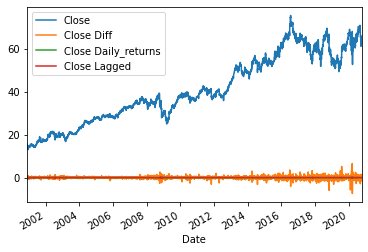

In [41]:
df.plot(xlim=(df.index[0], df.index[-1]))

# Garbage

In [62]:
def create_deep_rnn_model(hl=2, hu=100, layer='SimpleRNN',
                         optimizer='rmsprop', features=1,
                         dropout=False, rate=0.3, seed=100):
    
    if hl <= 2:
        hl = 2
    if layer == 'SimpleRNN':
        layer = SimpleRNN
    else:
        layer = LSTM
    
    model = Sequential()
    model.add(layer(hu, input_shape=(lags, features),
                   return_sequences=True))
    
    if dropout:
        model.add(Dropout(rate, seed=seed))
        
    for _ in range(2, hl):
        model.add(layer(hu, return_sequences=True))
        
        if dropout:
            model.add(Dropout(rate, seed=seed))
    
    model.add(layer(hu))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Book Example / Test

Epoch 1/6
39/39 [==============================] - 1s 17ms/step - loss: 0.0145ETA: 0s - los
Epoch 2/6
39/39 [==============================] - 1s 16ms/step - loss: 0.0398
Epoch 3/6
39/39 [==============================] - 1s 16ms/step - loss: 0.0316
Epoch 4/6
39/39 [==============================] - 1s 16ms/step - loss: 0.0176
Epoch 5/6
39/39 [==============================] - 1s 16ms/step - loss: 0.0106
Epoch 6/6
39/39 [==============================] - 1s 16ms/step - loss: 0.0109: 0s - loss: 0.010


0.012057456187903881


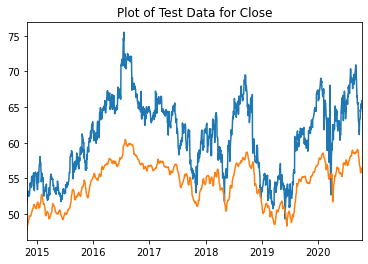

In [64]:
stock_close_series = df['Close']

df = stock_close_series.to_frame()
    
# The feature and target columns will be the only columns of the Series/DataFrame
# which is passed as a parameter of the function
feature_col_number = 0
target_col_number = 0
window_size = 10
epoch_len=6
learning_rate=3e-3

# Establishing Feature and Label
X = []
y = []
    
for i in range(len(df) - window_size):
    features = df.iloc[i : (i + window_size), feature_col_number]
    target = df.iloc[(i + window_size), target_col_number]
    X.append(features)
    y.append(target)
    
X, y = np.array(X), np.array(y).reshape(-1, 1)
    
# Establishing Split size
split = int(0.7 * len(X))
    
#Train/Test Split
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
        
#Scaling & Fitting the Data
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)
    
#Reshape Features
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
# Define the Sequential model.
model = Sequential()

# Initial model setup

# number_units should be equal to window_size
# MIT lecture series recommended 0.5 dropout, but Trilogy used 0.2

dropout_fraction = 0.5

# Layer 1
model.add(LSTM(
    units=window_size,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer
model.add(LSTM(units=3*window_size, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer
model.add(LSTM(units=3*window_size, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer
#model.add(LSTM(units=5*window_size, return_sequences=True))
#model.add(Dropout(dropout_fraction))
# Layer
#model.add(LSTM(units=4*window_size, return_sequences=True))
#model.add(Dropout(dropout_fraction))
# Layer
#model.add(LSTM(units=3*window_size, return_sequences=True))
#model.add(Dropout(dropout_fraction))
# Layer
#model.add(LSTM(units=2*window_size, return_sequences=True))
#model.add(Dropout(dropout_fraction))
# Layer
model.add(LSTM(units=1*window_size))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))
    
# Optimizer
#optimizer = keras.optimizers.SGD(lr=learning_rate)
    
# Compile the model
model.compile(optimizer='adam', loss="mean_squared_error")
    
# Model summary
#model.summary()
    
# Fit model
model.fit(X_train, y_train, epochs=epoch_len, shuffle=False, batch_size=90, verbose=1)
    
# Evaluate model
evaluation = model.evaluate(X_test, y_test, verbose=0)
print("\n")
print(evaluation)
    
# Make predictions using the testing data X_test
predicted = model.predict(X_test)
    
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
    
# Plot the real vs predicted prices as a line chart
#stocks.plot(title=f"Actual Vs. Predicted {stock_close_series.name} Price")
    
plt.title(f"Plot of Test Data for {stock_close_series.name}")
plt.plot(stocks)
plt.plot(predicted_prices, color='red')
plt.xlim([stocks.index[0], stocks.index[-1]])
plt.show()

# Coding Project Test

Epoch 1/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0144
Epoch 2/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0197
Epoch 3/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0156
Epoch 4/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0143
Epoch 5/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0105
Epoch 6/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0092
Epoch 7/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0081
Epoch 8/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0070
Epoch 9/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0069
Epoch 10/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0060
Epoch 11/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0056
Epoch 12/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0050
Epoch 13/50
39/39 [==================

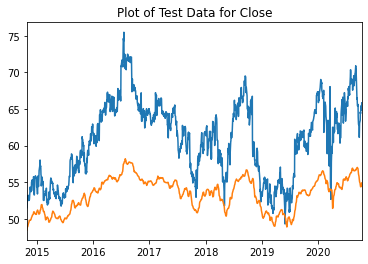

In [51]:
stock_close_series = df['Close']

df = stock_close_series.to_frame()
    
# The feature and target columns will be the only columns of the Series/DataFrame
# which is passed as a parameter of the function
feature_col_number = 0
target_col_number = 0
window_size = 10
epoch_len=50
learning_rate=3e-3

# Establishing Feature and Label
X = []
y = []
    
for i in range(len(df) - window_size):
    features = df.iloc[i : (i + window_size), feature_col_number]
    target = df.iloc[(i + window_size), target_col_number]
    X.append(features)
    y.append(target)
    
X, y = np.array(X), np.array(y).reshape(-1, 1)
    
# Establishing Split size
split = int(0.7 * len(X))
    
#Train/Test Split
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
        
#Scaling & Fitting the Data
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)
    
#Reshape Features
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
# number_units should be equal to window_size
dropout_fraction = 0.5

# Layer 1
model.add(LSTM(
    units=window_size,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=3*window_size, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=2*window_size, return_sequences=True))
model.add(Dropout(dropout_fraction))
    
# Layer 4
model.add(LSTM(units=1*window_size))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))
    
# Optimizer
#optimizer = keras.optimizers.SGD(lr=learning_rate)
    
# Compile the model
model.compile(optimizer='adam', loss="mean_squared_error")
    
# Model summary
#model.summary()
    
# Fit model
model.fit(X_train, y_train, epochs=epoch_len, shuffle=False, batch_size=90, verbose=1)
    
# Evaluate model
evaluation = model.evaluate(X_test, y_test, verbose=0)
print("\n")
print(evaluation)
    
# Make predictions using the testing data X_test
predicted = model.predict(X_test)
    
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
    
# Plot the real vs predicted prices as a line chart
#stocks.plot(title=f"Actual Vs. Predicted {stock_close_series.name} Price")
    
plt.title(f"Plot of Test Data for {stock_close_series.name}")
plt.plot(stocks)
plt.plot(predicted_prices, color='red')
plt.xlim([stocks.index[0], stocks.index[-1]])
plt.show()

# Coding Project Original Function

In [52]:
def rnnLSTM(stock_close_series, train_size=0.60, window_size=10, epoch_len=10, learning_rate=3e-3):
    """
    Function creates and fits an RNN LSTM model to stock_close_series data, which
    should be in the form of a pandas.Series object.
    
    Window size is equal to number of units in the Sequential model.
    """
    df = stock_close_series.to_frame()
    
    # The feature and target columns will be the only columns of the Series/DataFrame
    # which is passed as a parameter of the function
    feature_col_number = 0
    target_col_number = 0
    
    # Establishing Feature and Label
    X = []
    y = []
    
    for i in range(len(df) - window_size):
        features = df.iloc[i : (i + window_size), feature_col_number]
        target = df.iloc[(i + window_size), target_col_number]
        X.append(features)
        y.append(target)
    
    X, y = np.array(X), np.array(y).reshape(-1, 1)
    
    # Establishing Split size
    split = int(train_size * len(X))
    
    #Train/Test Split
    X_train = X[: split]
    X_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]
        
    #Scaling & Fitting the Data
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    
    #Reshape Features
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Define the LSTM RNN model.
    model = Sequential()

    # Initial model setup
    # number_units should be equal to window_size
    dropout_fraction = 0.5

    # Layer 1
    model.add(LSTM(
        units=window_size,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))

    # Layer 2
    model.add(LSTM(units=3*window_size, return_sequences=True))
    model.add(Dropout(dropout_fraction))

    # Layer 3
    model.add(LSTM(units=2*window_size, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    
    # Layer 4
    model.add(LSTM(units=1*window_size))
    model.add(Dropout(dropout_fraction))

    # Output layer
    model.add(Dense(1))
    
    # Optimizer
    #optimizer = keras.optimizers.SGD(lr=learning_rate)
    
    # Compile the model
    model.compile(optimizer='adam', loss="mean_squared_error")
    
    # Model summary
    #model.summary()
    
    # Fit model
    model.fit(X_train, y_train, epochs=epoch_len, shuffle=False, batch_size=90, verbose=1)
    
    # Evaluate model
    evaluation = model.evaluate(X_test, y_test, verbose=0)
    print("\n")
    print(evaluation)
    
    # Make predictions using the testing data X_test
    predicted = model.predict(X_test)
    
    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Create a DataFrame of Real and Predicted values
    stocks = pd.DataFrame({
        "Actual": real_prices.ravel(),
        "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ]) 
    
    # Plot the real vs predicted prices as a line chart
    #stocks.plot(title=f"Actual Vs. Predicted {stock_close_series.name} Price")
    
    plt.title(f"Plot of Test Data for {stock_close_series.name}")
    plt.plot(stocks)
    plt.plot(predicted_prices, color='red')
    plt.xlim([stocks.index[0], stocks.index[-1]])
    plt.show()
    
    pass

# Coding Project Original ARIMA Function

In [35]:
def arima(df_series_obj, split_size=0.75, p=2, d=1, q=0):
    """
    Takes in a pandas.series object and creates an ARIMA model around the values given
    
    Default Train/Test split is 75/25
    
    Default ARIMA(p,d,q) = (7,1,0)
    
    (If closing prices and passed, RMSE & MSE will be in USD.)
    """
    # Establish X Feature as series values
    X = df_series_obj.values
    
    # Train/Test/Split Size
    size = int(len(X) * split_size)
    train, test = X[0:size], X[size:len(X)]
    
    # Number of Predictions
    #print(f"Number of Predictions to run: {len(test)}")
    
    #History of close values
    history = [x for x in train]
    
    #Empty Predictions list for appending forecasted values
    predictions = list()
    
    #Loop through Test set and compare predicted with expected values
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        
        # Print Function Commented out to clean output
        #print('predicted=%.2f, expected=%.2f' %(yhat, obs))
    
    # Figure out MSE/RMSE error report
    error = mean_squared_error(test, predictions)
    rmse = np.sqrt(error)
    
    # Print Error report in dollar values
    print(f'Results for {df_series_obj.name}')
    print('Test MSE of: %.3f' % error)
    print('Test RMSE of: %.3f' % rmse)
    
    print(model_fit.summary())
    
    # Return plot of performance
    plt.title(f"Plot for {df_series_obj.name}")
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()
    
    pass

C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results for Close
Test MSE of: 0.807
Test RMSE of: 0.898
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5000
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4180.977
Method:                       css-mle   S.D. of innovations              0.558
Date:                Tue, 17 Nov 2020   AIC                           8369.954
Time:                        21:31:14   BIC                           8396.023
Sample:                             1   HQIC                          8379.091
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.007      1.331      0.183      -0.005       0.025
ar.L1.D.y     -0.0321      0.014     -2.274      0.023      -0.060      -0

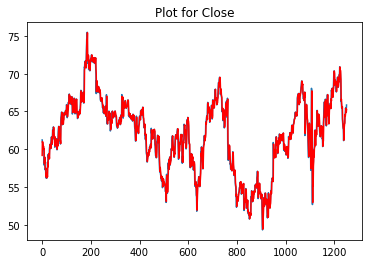

In [36]:
arima(df['Close'])